In [1]:
# Get all followups
from rdkit import Chem
from typing import Dict

with Chem.SDMolSupplier('hits.filtered.sdf') as sd:
    hitdex: Dict[str, Chem.Mol] = {mol.GetProp('_Name'): mol for mol in sd}

In [2]:
import requests
import pandas as pd

# https://arthor.docking.org/api.html

base_url = 'https://arthor.docking.org/'

dbs = pd.DataFrame( requests.get(base_url + 'dt/data').json() )
dbs

,displayName,location,idHref,structHref,lastModified,priority,urlFormatStr,idxTypes,indexes
0,aggpage,/local2/public_arthor/aggpage.smi,None,None,1686269019226,1,None,"[SIM, SUB]","[{'type': 'SUB', 'file': '/local2/public_artho..."
1,BB-10-22Q1,/local2/public_arthor/bb_10.smi,None,None,1686270814607,2,None,"[SIM, SUB]","[{'type': 'SUB', 'file': '/local2/public_artho..."
2,BB-20-22Q1,/local2/public_arthor/bb_20.smi,None,None,1686270883961,3,None,"[SIM, SUB]","[{'type': 'SUB', 'file': '/local2/public_artho..."
3,BB-30-22Q1\t,/local2/public_arthor/bb_30.smi,None,None,1686270897257,4,None,"[SIM, SUB]","[{'type': 'SUB', 'file': '/local2/public_artho..."
4,BB-40-22Q1\t,/local2/public_arthor/bb_40.smi,None,None,1686270897569,5,None,"[SIM, SUB]","[{'type': 'SUB', 'file': '/local2/public_artho..."
5,BB-50-22Q1\t,/local2/public_arthor/bb_50.smi,None,None,1686270898747,6,None,"[SIM, SUB]","[{'type': 'SUB', 'file': '/local2/public_artho..."
6,BB-ForSale-22Q1,/local2/public_arthor/bb_forsale.smi,None,None,1686270917296,7,None,"[SIM, SUB]","[{'type': 'SUB', 'file': '/local2/public_artho..."
7,BB-InStock-22Q1,/local2/public_arthor/bb_instock.smi,None,None,1686270999562,8,None,"[SIM, SUB]","[{'type': 'SUB', 'file': '/local2/public_artho..."
8,ChemSpace-BB-Stock-Mar2022-712K,/local2/public_arthor/Enamine-BB-Stock-Mar2022...,None,None,1686271002561,9,None,"[SIM, SUB]","[{'type': 'SUB', 'file': '/local2/public_artho..."
9,ChemSpace-SC-Stock-Mar2022-346K\t,/local2/public_arthor/Enamine-SC-Stock-Mar2022...,None,None,1686271004793,10,None,"[SIM, SUB]","[{'type': 'SUB', 'file': '/local2/public_artho..."


In [3]:
## Get table of SMARTS

# no need to escape (%2C)
#dbname=','.join(['BB-50-22Q1', 'MADE-BB-23Q1-770M', 'Mcule-BB-22Q1-2.1M', 'ChemSpace-BB-Stock-Mar2022-712K', 'zinc20-forsale-22q1', 'REAL-Database-22Q1', 'Mcule-Ultimate-20Q2-126M'])
dbname=','.join(['BB-ForSale-22Q1', 'REAL-Database-22Q1', 'MADE-BB-23Q1-770M'])

#query = 'a1aa2[cX3H0][aH0X2][aH0X2]a2[aX2]a1'
query = '[aH0X3]([#6,#7,#8])1[c,n](-[Br,Cl,NH2])[aH0X2][aH0X2]a1.N-S(=O)(=O)-C'

from rdkit.Chem import PandasTools, Draw, AllChem
response = requests.get(base_url + f'/dt/{dbname}/search', dict(query=query,
                                                               type='SMARTS',
                                                               length=1_000_000)
                       )

assert response.json()['recordsTotal']
matches = pd.DataFrame( response.json()['data'], columns=['idx', 'smiles_id', 'empty', 'something', 'db'])
matches['id'] = matches.smiles_id.str.split(expand=True)[1]
matches['smiles'] = matches.smiles_id.str.split(expand=True)[0]
matches.drop_duplicates('id')
PandasTools.AddMoleculeColumnToFrame(matches,'smiles','mol',includeFingerprints=True)
matches = matches.loc[~matches.mol.isnull()]
matches = matches.reset_index(drop=True)
# tabs?
matches['db'] = matches.db.str.strip()
matches['N_RB'] = matches.mol.apply(AllChem.CalcNumRotatableBonds)
matches['N_HA'] = matches.mol.apply(AllChem.CalcNumHeavyAtoms)
matches

,idx,smiles_id,empty,something,db,id,smiles,mol,N_RB,N_HA
0,0,CC(C)(CNC(=O)c1nonc1N)NS(C)(=O)=O ZINC00011173...,,1055303,BB-ForSale-22Q1,ZINC000111735757,CC(C)(CNC(=O)c1nonc1N)NS(C)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x1398f8430>,5,18
1,1,CS(=O)(=O)N[C@@H]1CCN(Cc2nnsc2Cl)C1 ZINC000116...,,1464750,BB-ForSale-22Q1,ZINC000116892228,CS(=O)(=O)N[C@@H]1CCN(Cc2nnsc2Cl)C1,<rdkit.Chem.rdchem.Mol object at 0x1398f8510>,4,17
2,2,CS(=O)(=O)N[C@H]1CCN(Cc2nnsc2Cl)C1 ZINC0001168...,,1464751,BB-ForSale-22Q1,ZINC000116892230,CS(=O)(=O)N[C@H]1CCN(Cc2nnsc2Cl)C1,<rdkit.Chem.rdchem.Mol object at 0x1398f85f0>,4,17
3,3,O=S(=O)(NC1CC1)[C@@H]1CCN(Cc2nnsc2Cl)C1 ZINC00...,,1865297,BB-ForSale-22Q1,ZINC000120819967,O=S(=O)(NC1CC1)[C@@H]1CCN(Cc2nnsc2Cl)C1,<rdkit.Chem.rdchem.Mol object at 0x1398f86d0>,5,19
4,4,O=S(=O)(NC1CC1)[C@H]1CCN(Cc2nnsc2Cl)C1 ZINC000...,,1865299,BB-ForSale-22Q1,ZINC000120820164,O=S(=O)(NC1CC1)[C@H]1CCN(Cc2nnsc2Cl)C1,<rdkit.Chem.rdchem.Mol object at 0x1398f87b0>,5,19
...,...,...,...,...,...,...,...,...,...,...
24807,24807,Br/C=C\CS(=O)(=O)NCc1conc1Br CSMB06827890312,,763620030,MADE-BB-23Q1-770M,CSMB06827890312,Br/C=C\CS(=O)(=O)NCc1conc1Br,<rdkit.Chem.rdchem.Mol object at 0x13d414eb0>,5,15
24808,24808,Cc1c(N)nsc1N2CC3(C2)CN(C3)S(=O)(=O)C CSMB06827...,,763624497,MADE-BB-23Q1-770M,CSMB06827894807,Cc1c(N)nsc1N2CC3(C2)CN(C3)S(=O)(=O)C,<rdkit.Chem.rdchem.Mol object at 0x13d414f90>,2,18
24809,24809,CS(=O)(=O)N1CC2(CN(C2)c3nsnc3Cl)C1 CSMB0682832...,,764051621,MADE-BB-23Q1-770M,CSMB06828324137,CS(=O)(=O)N1CC2(CN(C2)c3nsnc3Cl)C1,<rdkit.Chem.rdchem.Mol object at 0x13d415070>,2,17
24810,24810,Cn1c(Br)nnc1CCNS(=O)(=O)CC2CCN2 CSMB06832072135,,767776427,MADE-BB-23Q1-770M,CSMB06832072135,Cn1c(Br)nnc1CCNS(=O)(=O)CC2CCN2,<rdkit.Chem.rdchem.Mol object at 0x13d415150>,6,18


In [5]:
from fragmenstein import Monster
from contextlib import suppress
from rdkit.rdBase import BlockLogs

class SmartMonsterHandler:
    """
    Given hits and a SMARTS query w/ dot separated patterns,
    wherein each sequentially matches the hits
    
    ... code-block:: python
        sm = SmartMonsterHandler([hit1, hit2], query, joining_cutoff=10)
        sm(matches.mol[0])
        
    or 
    
    ... code-block:: python
        sm = SmartMonsterHandler([hit1, hit2], query, joining_cutoff=10)
        results = matches.mol.apply(sm)
        matches['success'] = results.loc[~results.isna()].apply(operator.itemgetter('success'))
        matches['ddG'] = results.loc[~results.isna()].apply(operator.itemgetter('ddG'))
        matches['minimized_mol'] = results.loc[~results.isna()].apply(operator.itemgetter('mol'))
        
"""
    def __init__(self, hits, query, **monster_options):
        self.hits = hits
        self.monster_options = monster_options
        self.names = [h.GetProp('_Name') for h in self.hits]
        self.smols = [Chem.MolFromSmarts(q) for q in query.split('.')]
        self.mappings = [h.GetSubstructMatch(smol) for h, smol in zip(self.hits, self.smols)]
        assert all([len(m) > 0 for m in self.mappings]), 'The query does not match the hits'
        self._exception = Exception
        
    def map(self, mol):
        return {n: dict(zip(m, mol.GetSubstructMatch(s))) for n, m, s in zip(self.names, self.mappings, self.smols)}
    
    def __call__(self, mol):
        monster = Monster(self.hits, **self.monster_options)
        mapping = self.map(mol)
        with suppress(self._exception), BlockLogs():
            monster.place(mol, custom_map=mapping)
            used_map = monster.convert_origins_to_custom_map()
            success = monster.mmff_minimize(allow_lax=False)
            ddG = monster.MMFF_score()
            if any([len(set(mapping[name].items()) - set(used_map[name].items())) != 0 for name in self.names]):
                success = False
                ddG = float('nan')
            return {'mol': monster.positioned_mol,
                    'custom_map': mapping,
                    'success': success,
                    'ddG': ddG
                  }
        return {'mol': mol, 'custom_map': mapping, 'success': False, 'ddG': float('nan')}

In [6]:
matches = matches.sort_values('N_HA').reset_index(drop=True)

In [10]:
import operator

results = matches.mol.apply(SmartMonsterHandler([x1594, fippedSulfonamide], query, joining_cutoff=10))
matches['success'] = results.loc[~results.isna()].apply(operator.itemgetter('success'))
matches['ddG'] = results.loc[~results.isna()].apply(operator.itemgetter('ddG'))
matches['minimized_mol'] = results.loc[~results.isna()].apply(operator.itemgetter('mol'))

In [12]:
matches['success'].value_counts()

success
False    16437
True      8375
Name: count, dtype: int64

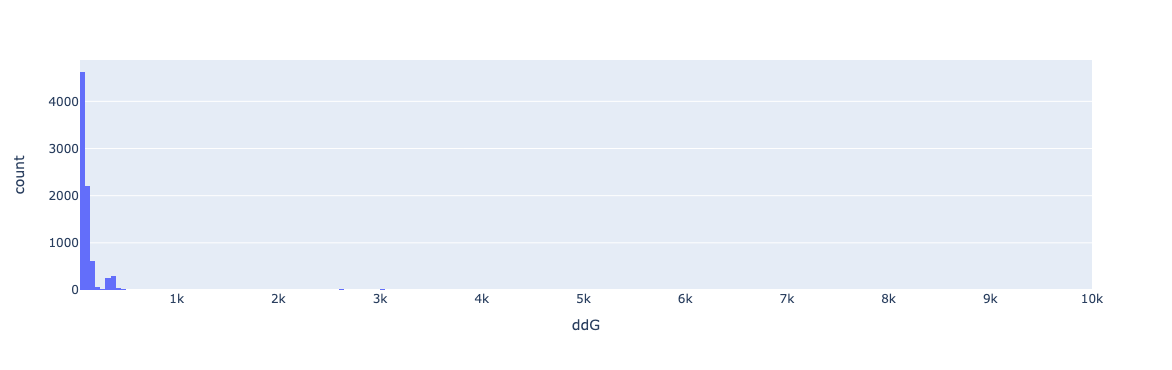

In [13]:
import plotly.express as px

px.histogram(matches.loc[matches['success']], 'ddG')

In [ ]:
### JUNKYARD

In [ ]:
matches

In [25]:
from rdkit.Chem import PandasTools

PandasTools.WriteSDF(matches.loc[matches['success'] & (matches['N_RB'] <= 3)].sort_values('ddG', ascending=True).head(100), 'arthorian-wormless.sdf', 'minimized_mol', 'id')


In [33]:
matches['bad_normalised'] = (matches['ddG'] / matches['N_HA'] * matches['success'].apply(lambda b: 1 if b else float('inf'))).fillna(float('inf'))

In [37]:
matches.sort_values('bad_normalised')

,idx,smiles_id,empty,something,db,id,smiles,mol,N_RB,N_HA,success,ddG,minimized_mol,bad_normalised
13627,23559,Cc1nsc(Br)c1CNCCCNS(=O)(=O)C(F)(F)F CSMB063375...,,477273315,MADE-BB-23Q1-770M,CSMB06337524535,Cc1nsc(Br)c1CNCCCNS(=O)(=O)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x13cfc0120>,7,20,True,64.422583,<rdkit.Chem.rdchem.RWMol object at 0x28eb46070>,3.221129
8527,23241,Cc1nsc(Br)c1CNCCNS(=O)(=O)C(F)(F)F CSMB0631039...,,450579981,MADE-BB-23Q1-770M,CSMB06310396582,Cc1nsc(Br)c1CNCCNS(=O)(=O)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x13cfaa810>,6,19,True,63.715777,<rdkit.Chem.rdchem.RWMol object at 0x28736e390>,3.353462
6784,22940,NS(=O)(=O)CCCCCCNCc1csnc1Br CSMB06290041514,,430574712,MADE-BB-23Q1-770M,CSMB06290041514,NS(=O)(=O)CCCCCCNCc1csnc1Br,<rdkit.Chem.rdchem.Mol object at 0x13cf95e70>,9,18,True,60.925267,<rdkit.Chem.rdchem.RWMol object at 0x284d34d10>,3.384737
24532,6765,CC1=NOC(Cl)=C1CC(=O)NCC1=CC=C(CS(=O)(=O)NC(C)C...,,1245730115,REAL-Database-22Q1,Z999181268,CC1=NOC(Cl)=C1CC(=O)NCC1=CC=C(CS(=O)(=O)NC(C)C...,<rdkit.Chem.rdchem.Mol object at 0x13995d7e0>,8,26,True,88.393808,<rdkit.Chem.rdchem.RWMol object at 0x2b8c20b30>,3.399762
20573,3856,N#CC1=CC=C(CS(=O)(=O)NCCC2=CON=C2Br)C(F)=C1 PV...,,348855629,REAL-Database-22Q1,PV-007049462174,N#CC1=CC=C(CS(=O)(=O)NCCC2=CON=C2Br)C(F)=C1,<rdkit.Chem.rdchem.Mol object at 0x13973d000>,6,22,True,75.071034,<rdkit.Chem.rdchem.RWMol object at 0x298f81080>,3.412320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9581,13856,CN1N=NC(Br)=C1CNS(=O)(=O)C1CCCC1C#N PV-0027287...,,122465381,REAL-Database-22Q1,PV-002728790852,CN1N=NC(Br)=C1CNS(=O)(=O)C1CCCC1C#N,<rdkit.Chem.rdchem.Mol object at 0x13b238ba0>,4,19,False,NaN,<rdkit.Chem.rdchem.RWMol object at 0x28878ad90>,inf
9573,19617,NC1=NSC(NCCS(N)(=O)=O)=C1C(=O)NC1CC1 CSMB02222...,,198346280,MADE-BB-23Q1-770M,CSMB02222507897,NC1=NSC(NCCS(N)(=O)=O)=C1C(=O)NC1CC1,<rdkit.Chem.rdchem.Mol object at 0x13c9b68f0>,6,19,False,351.320411,<rdkit.Chem.rdchem.RWMol object at 0x28876c090>,inf
9571,13914,CC1=NSC(Br)=C1C(=O)N[C@H]1C[C@@H](CS(N)(=O)=O)...,,124748629,REAL-Database-22Q1,PV-006756310686,CC1=NSC(Br)=C1C(=O)N[C@H]1C[C@@H](CS(N)(=O)=O)C1,<rdkit.Chem.rdchem.Mol object at 0x13b23be60>,4,19,False,137.868335,<rdkit.Chem.rdchem.RWMol object at 0x2887b3240>,inf
9594,11677,CS(=O)(=O)N1CC(C2=NC(C3=CSN=C3Br)=NO2)C1 Z4255...,,33091321,REAL-Database-22Q1,Z4255033014,CS(=O)(=O)N1CC(C2=NC(C3=CSN=C3Br)=NO2)C1,<rdkit.Chem.rdchem.Mol object at 0x13aca4820>,3,19,False,207.014511,<rdkit.Chem.rdchem.RWMol object at 0x288996bb0>,inf


,idx,smiles_id,empty,something,db,id,smiles,mol,N_RB,N_HA,success,ddG,minimized_mol,bad_normalised
18843,1406,CN1N=NC(Br)=C1CN1CCCCCCCNS(=O)(=O)CC1 Z3518710315,,54580951,REAL-Database-22Q1,Z3518710315,CN1N=NC(Br)=C1CN1CCCCCCCNS(=O)(=O)CC1,<rdkit.Chem.rdchem.Mol object at 0x139669d20>,2,22,True,76.007334,<rdkit.Chem.rdchem.RWMol object at 0x2966f6c00>,3.454879
17906,8025,O=S1(=O)CCN(CC2=C(Cl)SN=N2)CCCCCCCN1 Z3518705919,,4185253348,REAL-Database-22Q1,Z3518705919,O=S1(=O)CCN(CC2=C(Cl)SN=N2)CCCCCCCN1,<rdkit.Chem.rdchem.Mol object at 0x1399aeff0>,2,21,True,74.121902,<rdkit.Chem.rdchem.RWMol object at 0x29508bab0>,3.529614
22794,4448,CC1=NOC(Cl)=C1CC(=O)N1CCCCCCCNS(=O)(=O)CC1 Z36...,,459771626,REAL-Database-22Q1,Z3626805493,CC1=NOC(Cl)=C1CC(=O)N1CCCCCCCNS(=O)(=O)CC1,<rdkit.Chem.rdchem.Mol object at 0x1398a5a80>,2,24,True,86.274391,<rdkit.Chem.rdchem.RWMol object at 0x2b6074ef0>,3.594766
21317,1408,CC1=NOC(Cl)=C1CC(=O)N1CCCCCCNS(=O)(=O)CC1 Z358...,,55139982,REAL-Database-22Q1,Z3585681785,CC1=NOC(Cl)=C1CC(=O)N1CCCCCCNS(=O)(=O)CC1,<rdkit.Chem.rdchem.Mol object at 0x139669ee0>,2,23,True,83.239491,<rdkit.Chem.rdchem.RWMol object at 0x29a2424d0>,3.619108
10395,16332,CNC(C1CCCN(C)S1(=O)=O)C1=C(Br)SN=C1C CSMB00108...,,50308728,MADE-BB-23Q1-770M,CSMB00108472029,CNC(C1CCCN(C)S1(=O)=O)C1=C(Br)SN=C1C,<rdkit.Chem.rdchem.Mol object at 0x13b2dd540>,3,19,True,71.291723,<rdkit.Chem.rdchem.RWMol object at 0x289b34d60>,3.752196
23774,5304,CC(C(=O)N1CCCN(C(=O)C2=CSN=C2Cl)CCC1)S(N)(=O)=...,,602407185,REAL-Database-22Q1,PV-005150618526,CC(C(=O)N1CCCN(C(=O)C2=CSN=C2Cl)CCC1)S(N)(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x139818e40>,3,24,True,90.104273,<rdkit.Chem.rdchem.RWMol object at 0x2b7b04180>,3.754345
22095,4929,CC1CCN(C(=O)C(C)S(N)(=O)=O)CCN1C(=O)C1=CSN=C1C...,,552627244,REAL-Database-22Q1,PV-004585691230,CC1CCN(C(=O)C(C)S(N)(=O)=O)CCN1C(=O)C1=CSN=C1Cl,<rdkit.Chem.rdchem.Mol object at 0x139854350>,3,24,True,90.660158,<rdkit.Chem.rdchem.RWMol object at 0x2b4f560c0>,3.777507
10447,7823,CN1N=NC(Br)=C1CN1CCCC(S(N)(=O)=O)CC1 Z5432085449,,4177078972,REAL-Database-22Q1,Z5432085449,CN1N=NC(Br)=C1CN1CCCC(S(N)(=O)=O)CC1,<rdkit.Chem.rdchem.Mol object at 0x1399a3d80>,3,19,True,72.951364,<rdkit.Chem.rdchem.RWMol object at 0x289b87920>,3.839545
23458,5886,NC1=NOC2=CC=C(CN3CCCCCCNS(=O)(=O)CC3)C=C12 PV-...,,680796606,REAL-Database-22Q1,PV-002381818180,NC1=NOC2=CC=C(CN3CCCCCCNS(=O)(=O)CC3)C=C12,<rdkit.Chem.rdchem.Mol object at 0x139925000>,2,24,True,92.836633,<rdkit.Chem.rdchem.RWMol object at 0x2b71a3ba0>,3.868193
10404,16363,CCN1CCCC(C(O)C2=C(Br)SN=C2C)S1(=O)=O CSMB00108...,,50313753,MADE-BB-23Q1-770M,CSMB00108478996,CCN1CCCC(C(O)C2=C(Br)SN=C2C)S1(=O)=O,<rdkit.Chem.rdchem.Mol object at 0x13b2df060>,3,19,True,73.540150,<rdkit.Chem.rdchem.RWMol object at 0x289b34a90>,3.870534


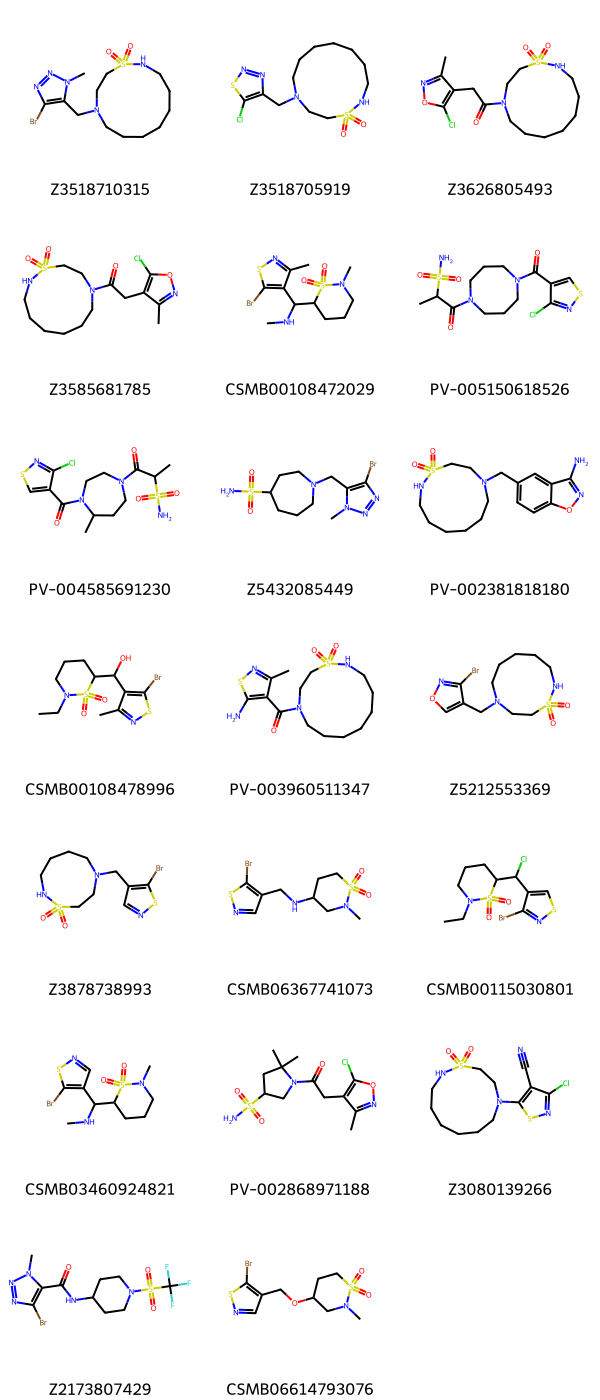

In [40]:
best = matches.loc[matches.N_RB <= 3].sort_values('bad_normalised').head(20)
display(best)
Draw.MolsToGridImage(best.mol, legends=best['id'].to_list())

[[],
 ['fippedSulfonamide.4'],
 [],
 ['x1594_0A§1.8'],
 ['x1594_0A§1.6'],
 ['x1594_0A§1.4'],
 [],
 [],
 ['x1594_0A§1.2'],
 ['x1594_0A§1.5'],
 ['x1594_0A§1.7'],
 ['x1594_0A§1.9'],
 ['fippedSulfonamide.1'],
 ['fippedSulfonamide.0'],
 ['fippedSulfonamide.3'],
 ['fippedSulfonamide.2']]

In [91]:
monstah.convert_origins_to_custom_map()

{'x1594_0A§1': {-2: 1,
  8: 3,
  6: 4,
  4: 5,
  2: 8,
  5: 9,
  7: 10,
  9: 11,
  -13: 12,
  -14: 13,
  -15: 14,
  -16: 15},
 'fippedSulfonamide': {4: 1,
  -4: 3,
  -5: 4,
  -6: 5,
  -9: 8,
  -10: 9,
  -11: 10,
  -12: 11,
  1: 12,
  0: 13,
  2: 14,
  3: 15}}

In [62]:
from fragmenstein import Victor
import logging

Victor.enable_stdout(logging.DEBUG)

mol = matches.mol[1106]

monstah = Monster([x1594, fippedSulfonamide], joining_cutoff=10)
monstah.place(mol)


[2023-07-07 12:56:41,154] DEBUG - Merge ligands: False. Broad search: True
[2023-07-07 12:56:41,163] DEBUG - `get_mcs_mappings` strict_maps for x1594_0A§1: [((2, 8), (4, 5), (5, 10), (6, 4)), ((2, 8), (4, 5), (6, 4), (7, 10)), ((6, 4), (7, 10), (8, 5), (9, 8))]
[2023-07-07 12:56:41,171] DEBUG - Merge ligands: False. Broad search: True
[2023-07-07 12:56:41,174] DEBUG - `get_mcs_mappings` strict_maps for fippedSulfonamide: [((0, 13), (1, 12), (2, 14), (3, 15), (4, 1)), ((0, 13), (1, 12), (2, 15), (3, 14), (4, 1))]
[2023-07-07 12:56:41,177] DEBUG - Primary hit: fippedSulfonamide with 2 Primary maps: [{0: 13, 1: 12, 2: 14, 3: 15, 4: 1}, {0: 13, 1: 12, 2: 15, 3: 14, 4: 1}]
[2023-07-07 12:56:41,179] DEBUG - primary_map: {0: 13, 1: 12, 2: 14, 3: 15, 4: 1}
[2023-07-07 12:56:41,179] DEBUG - initial expanded map (primary + overlaps): {'x1594_0A§1': {-2: 13, -3: 12, -4: 14, -5: 15, -6: 1}, 'fippedSulfonamide': {0: 13, 1: 12, 2: 14, 3: 15, 4: 1}}
[2023-07-07 12:56:41,183] DEBUG - `get_mcs_mappings

In [69]:
from typing import List, Dict, Tuple
from fragmenstein.monster import Unmerge

primary_maps: List[Dict[int, int]]
primary_name = None
min_mode_index = 0
# primary_name as None chooses one, else the primary name provided is used:
primary_name, primary_maps = monstah._get_primary_maps(primary_name)
# -------------- Get the secondary hits --------------------------------
# positional_overlap is used by ``_expand_hit_atom_map_by_overlap``
# which is called by ``_get_unmerge_expansions``
positional_overlaps: Dict[Tuple[str, str], Dict[int, int]] = monstah._compute_overlaps()
        
unmergers: List[Unmerge] = monstah._get_unmerge_expansions(primary_name,
                                                        primary_maps,
                                                        positional_overlaps,
                                                        min_mode_index)

[2023-07-07 13:03:14,349] DEBUG - Merge ligands: False. Broad search: True
[2023-07-07 13:03:14,357] DEBUG - `get_mcs_mappings` strict_maps for x1594_0A§1: [((2, 8), (4, 5), (5, 10), (6, 4)), ((2, 8), (4, 5), (6, 4), (7, 10)), ((6, 4), (7, 10), (8, 5), (9, 8))]
[2023-07-07 13:03:14,367] DEBUG - Merge ligands: False. Broad search: True
[2023-07-07 13:03:14,370] DEBUG - `get_mcs_mappings` strict_maps for fippedSulfonamide: [((0, 13), (1, 12), (2, 14), (3, 15), (4, 1)), ((0, 13), (1, 12), (2, 15), (3, 14), (4, 1))]
[2023-07-07 13:03:14,372] DEBUG - Primary hit: fippedSulfonamide with 2 Primary maps: [{0: 13, 1: 12, 2: 14, 3: 15, 4: 1}, {0: 13, 1: 12, 2: 15, 3: 14, 4: 1}]
[2023-07-07 13:03:14,373] DEBUG - primary_map: {0: 13, 1: 12, 2: 14, 3: 15, 4: 1}
[2023-07-07 13:03:14,374] DEBUG - initial expanded map (primary + overlaps): {'x1594_0A§1': {-2: 13, -3: 12, -4: 14, -5: 15, -6: 1}, 'fippedSulfonamide': {0: 13, 1: 12, 2: 14, 3: 15, 4: 1}}
[2023-07-07 13:03:14,379] DEBUG - `get_mcs_mappings

In [77]:
positioned_mol, mol_options = monstah._place_unmerger_expansions(unmergers)

[2023-07-07 13:15:28,292] WARNING - [13:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[2023-07-07 13:15:28,299] WARNING - [13:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[2023-07-07 13:15:28,304] DEBUG - Place from map: using provided atom_map {13: 0, 12: 1, 14: 2, 15: 3, 1: 4, 8: 7, 5: 9, 10: 10, 4: 11}
[2023-07-07 13:15:28,306] DEBUG - alignment atoms for 0 ({0}): {(1, 1), (12, 12)}
[2023-07-07 13:15:28,307] DEBUG - alignment atoms for 2 ({2, 3}): {(4, 4), (1, 1), (12, 12), (5, 5)}
[2023-07-07 13:15:28,308] DEBUG - alignment atoms for 6 ({6, 7}): {(4, 4), (8, 8), (5, 5)}
[2023-07-07 13:15:28,308] DEBUG - alignment atoms for 9 ({9}): {(8, 8), (5, 5), (10, 10)}
[2023-07-07 13:15:28,309] DEBUG - alignment atoms for 11 ({11}): {(8, 8), (10, 10), (5, 5), (4, 4)}
[2023-07-07 13:15:28,310] WARNING - [13:15:28] Molecule does not have explicit Hs. Consider calling AddHs()
[2023-07-07 13:15:28,316] WARNING - [13:15:28] Molecule does not have explic

In [82]:
unmergers[0].combined

{13: 0, 12: 1, 14: 2, 15: 3, 1: 4, 8: 7, 5: 9, 10: 10, 4: 11}

In [89]:
monstah.oir

[[],
 ['fippedSulfonamide.4'],
 [],
 ['x1594_0A§1.8'],
 ['x1594_0A§1.6'],
 ['x1594_0A§1.4'],
 [],
 [],
 ['x1594_0A§1.2'],
 ['x1594_0A§1.5'],
 ['x1594_0A§1.7'],
 ['x1594_0A§1.9'],
 ['fippedSulfonamide.1'],
 ['fippedSulfonamide.0'],
 ['fippedSulfonamide.2'],
 ['fippedSulfonamide.3']]

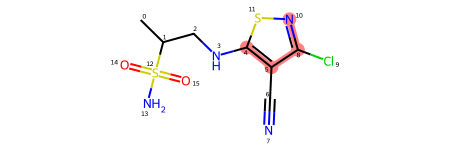

In [75]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

mol

In [327]:
um = monstah._perform_unmerge(maps={'x1594_0A§1': [{0: 14, 1: 13, 2: 10, 3: 12, 5: 11, 7: 9, 9: 8}], 'fippedSulfonamide': [{0: 7, 1: 4, 2: 5, 3: 6, 4: 1}]},
                         n_poisonous=3,
                       if self.throw_on_discard:
            hit_names = [h.GetProp('_Name') for h in self.hits]
            unmergers: List[Unmerge] = [u for u in unmergers if all([h in u.maps and len(u.maps[h]) and len(u.maps[h][0]) for h in hit_names])]
            if len(unmergers) == 0:
                raise DistanceError(hits=self.hits)
        if self.custom_map:
            unmerger: Unmerge
            for unmerger in unmergers:
                for name in self.custom_map:
                    if name not in unmerger.maps:
                        raise FragmensteinError(f'Custom map for {name} not in unmerger maps: {unmerger.maps}')
                    for h_idx, f_idx in self.custom_map[name].items():
                        pass
        # -------------- Sort the unmergers --------------------------------
        self.positioned_mol, self.mol_options = self._place_unmerger_expansions(unmergers)
        return self.positioned_mol          primary_name='x1594_0A§1')

[2023-07-05 12:59:01,145] DEBUG - followup to scaffold {14: 0, 13: 1, 10: 2, 12: 3, 11: 5, 9: 7, 8: 9}


In [57]:
provided_map

NameError: name 'provided_map' is not defined

In [340]:
provided_map = d['custom_map']
used_map = monstah.convert_origins_to_custom_map()

for key in provided_map:
    discrepancy = set(provided_map[key].items()) - set(used_map[key].items())
    if discrepancy:
        print(key, discrepancy)
        print(provided_map[key])
        print(used_map[key])

fippedSulfonamide {(2, 4), (4, 1), (0, 6), (1, 3), (3, 5)}
{0: 6, 1: 3, 2: 4, 3: 5, 4: 1}
{-7: 6, -8: 7, -9: 8, -10: 9, -11: 10, -12: 11, -13: 12, -14: 13}


In [342]:
Chem.MolToSmiles(matches.mol[1105])

'O=S(=O)(NCc1csnc1Br)C(F)F'

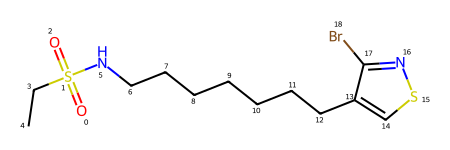

In [349]:
Chem.MolFromSmiles('O=S(=O)(CC)NCCCCCCCc1csnc1Br')

In [367]:
sm = SmartMonsterHandler([x1594, fippedSulfonamide], query, joining_cutoff=10)

sm._exception = ()

d = sm(Chem.MolFromSmiles('O=S(=O)(CC)NCCCCCCc1csnc1Br'))

viewer = py3Dmol.view(width=350, height=350)
IPythonConsole.addMolToView(sm.hits[0], viewer)
IPythonConsole.addMolToView(sm.hits[1], viewer)
IPythonConsole.addMolToView(d['mol'], viewer)
for idx,clr in zip(range(3),('magentaCarbon','cyanCarbon','whiteCarbon')):
    viewer.setStyle({'model':idx,}, {'stick':{'colorscheme':clr, 'opacity': 0.7}})
viewer.zoomTo()
print('**'*10)
print(d)
viewer.show()

[2023-07-05 13:28:22,437] DEBUG - Merge ligands: False. Broad search: True
[2023-07-05 13:28:22,451] DEBUG - `get_mcs_mappings` strict_maps for x1594_0A§1: [((0, 17), (1, 16), (2, 13), (3, 15), (4, 8), (5, 14), (6, 9), (7, 12), (8, 10), (9, 11))]
[2023-07-05 13:28:22,454] DEBUG - Merge ligands: False. Broad search: True
[2023-07-05 13:28:22,455] DEBUG - `get_mcs_mappings` strict_maps for fippedSulfonamide: [((0, 5), (1, 1), (2, 0), (3, 2), (4, 3))]
[2023-07-05 13:28:22,456] DEBUG - Primary hit: x1594_0A§1 with 1 Primary maps: [{0: 17, 1: 16, 2: 13, 3: 15, 4: 8, 5: 14, 6: 9, 7: 12, 8: 10, 9: 11}]
[2023-07-05 13:28:22,457] DEBUG - primary_map: {0: 17, 1: 16, 2: 13, 3: 15, 4: 8, 5: 14, 6: 9, 7: 12, 8: 10, 9: 11}
[2023-07-05 13:28:22,457] DEBUG - initial expanded map (primary + overlaps): {'x1594_0A§1': {0: 17, 1: 16, 2: 13, 3: 15, 4: 8, 5: 14, 6: 9, 7: 12, 8: 10, 9: 11}, 'fippedSulfonamide': {0: 5, 1: 1, 2: 0, 3: 2, 4: 3, -2: 17, -3: 16, -4: 13, -5: 15, -6: 8, -7: 14, -8: 9, -9: 12, -10: 

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

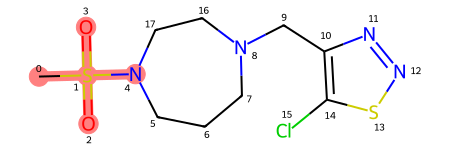

In [309]:
matches.mol[0]

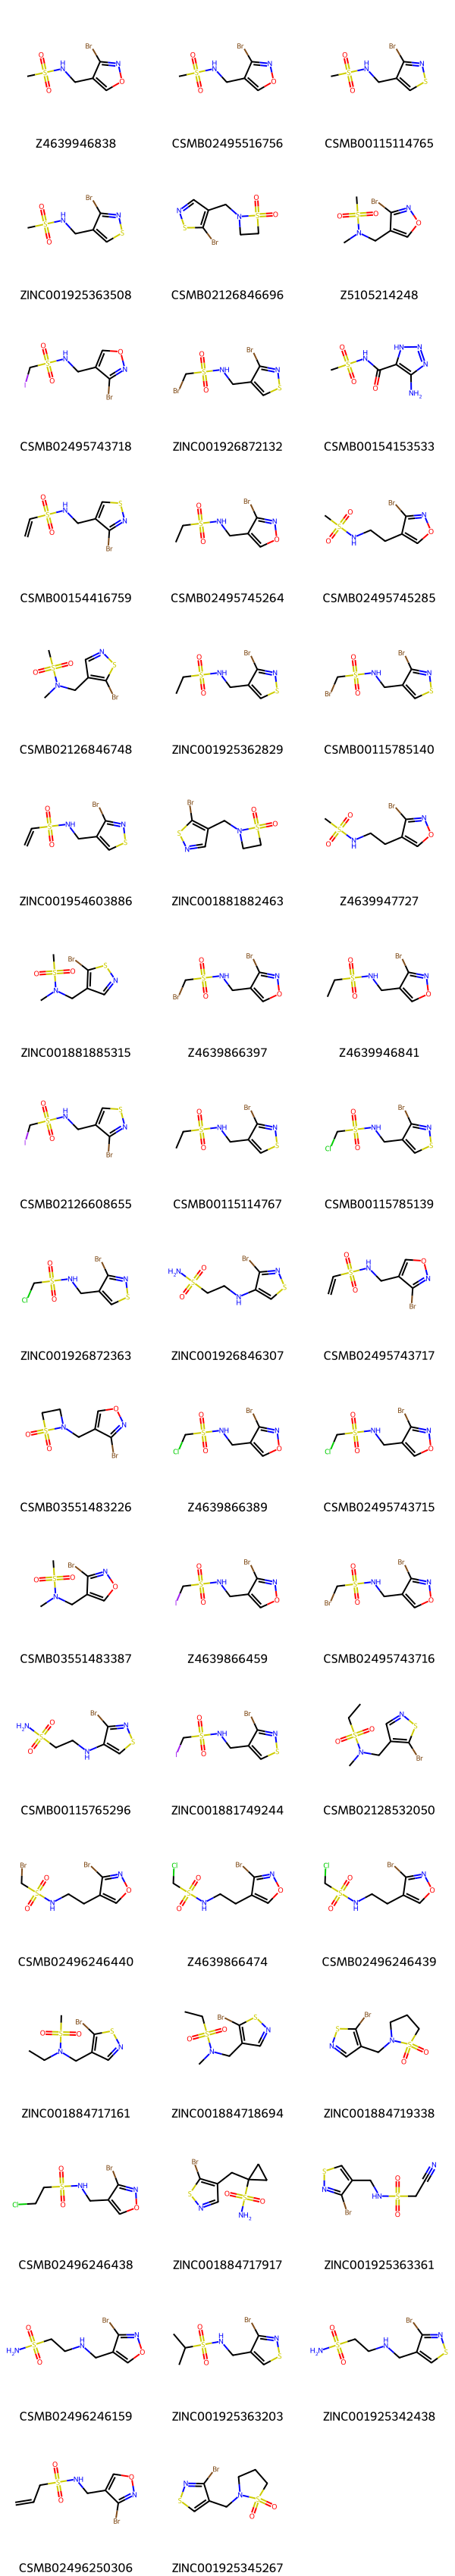

In [47]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(matches.sort_values('N_HA').head(50).mol, legends=matches.sort_values('N_HA').head(50)['id'].to_list())

In [71]:
Chem.MolFromSmiles(')

'c1cn2cnnc2cn1'

In [48]:
from rdkit.Chem import rdFMCS

Monster.matching_modes = [{'atomCompare': rdFMCS.AtomCompare.CompareElements,
                           'bondCompare': rdFMCS.BondCompare.CompareOrder,
                           'ringCompare': rdFMCS.RingCompare.PermissiveRingFusion,
                           'ringMatchesRingOnly': True}]

Monster([x1594, fippedSulfonamide]).place_smiles('CCCCCCCCCC')

Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
Provided mapping is very unfavourable... using that along for expanding the search
[16:36:46] Molecule does not have explicit Hs. Consider calling AddHs()
[16:36:46] Mole

In [ ]:
# '[aX3]1:[aX2]:[aH0X2]:[aH0X2]:[cX3]:1'

I generated the SMARTS manually. How would this be automated?
One option is show the atom indices and ask user to change the atoms.
Say idx 1: `c` is wanted as `[aX3]`

TODO: What is the context manager to supress RDKit warnings??

https://rdkit.readthedocs.io/en/latest/source/rdkit.RDLogger.html

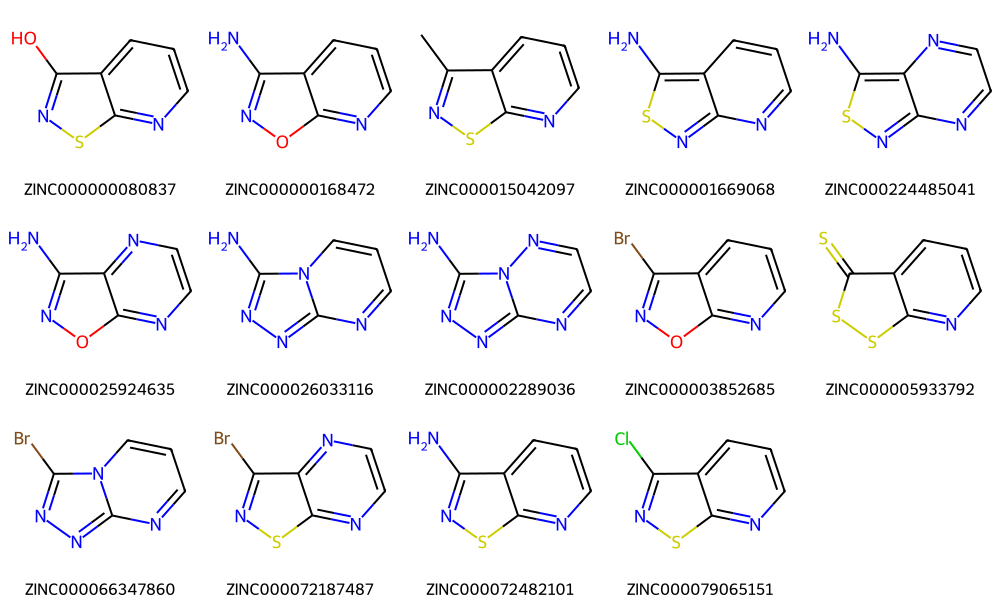

In [132]:
s = matches.loc[(matches.N_HA == 10) & (matches.db == 'BB-50-22Q1')]
drawing = Draw.MolsToGridImage(s.mol, legends=s.id.to_list(), molsPerRow=5)
with open('enamineBB_10HA.png', 'wb') as fh:
    fh.write(drawing.data)

drawing

In [139]:
bromo_smarts = Chem.MolFromSmarts('a1aa2[cX3H0](-Br)[aH0X2][aH0X2]a2[aX2]a1')
matches['bromo4thio'] = matches.mol >= bromo_smarts

ReadProperties: value line ignored
ReadProperties: buffer = 'V    1 a'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    2 a'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    3 a'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    4 [c&X3&H0]'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    5 Br'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    6 [a&H0&X2]'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    7 [a&H0&X2]'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    8 a'
ReadProperties: value line ignored
ReadProperties: buffer = 'V    9 [a&X2]'
ReadProperties: value line ignored
ReadProperties: buffer = 'V   10 a'


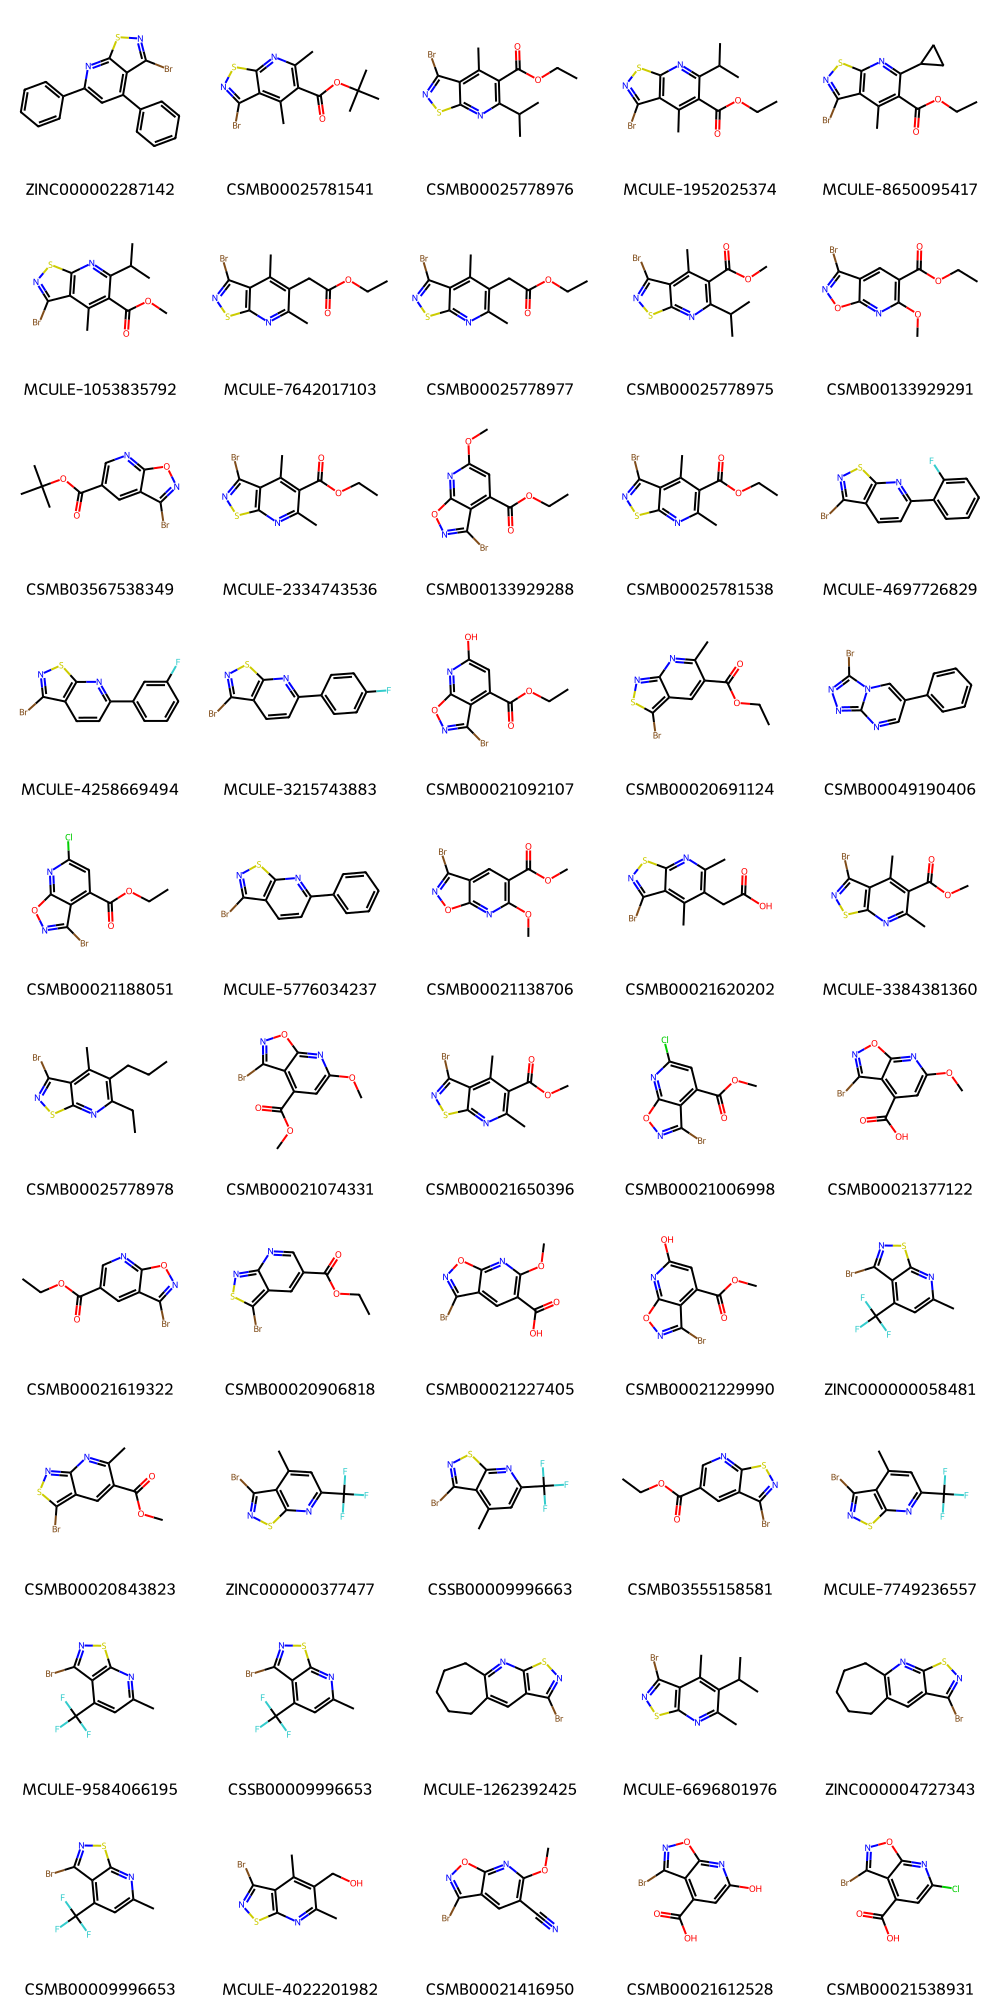

In [141]:
s = matches.loc[matches.bromo4thio].sort_values('N_HA', ascending=False)
Draw.MolsToGridImage(s.mol, legends=s.id.to_list(), molsPerRow=5)

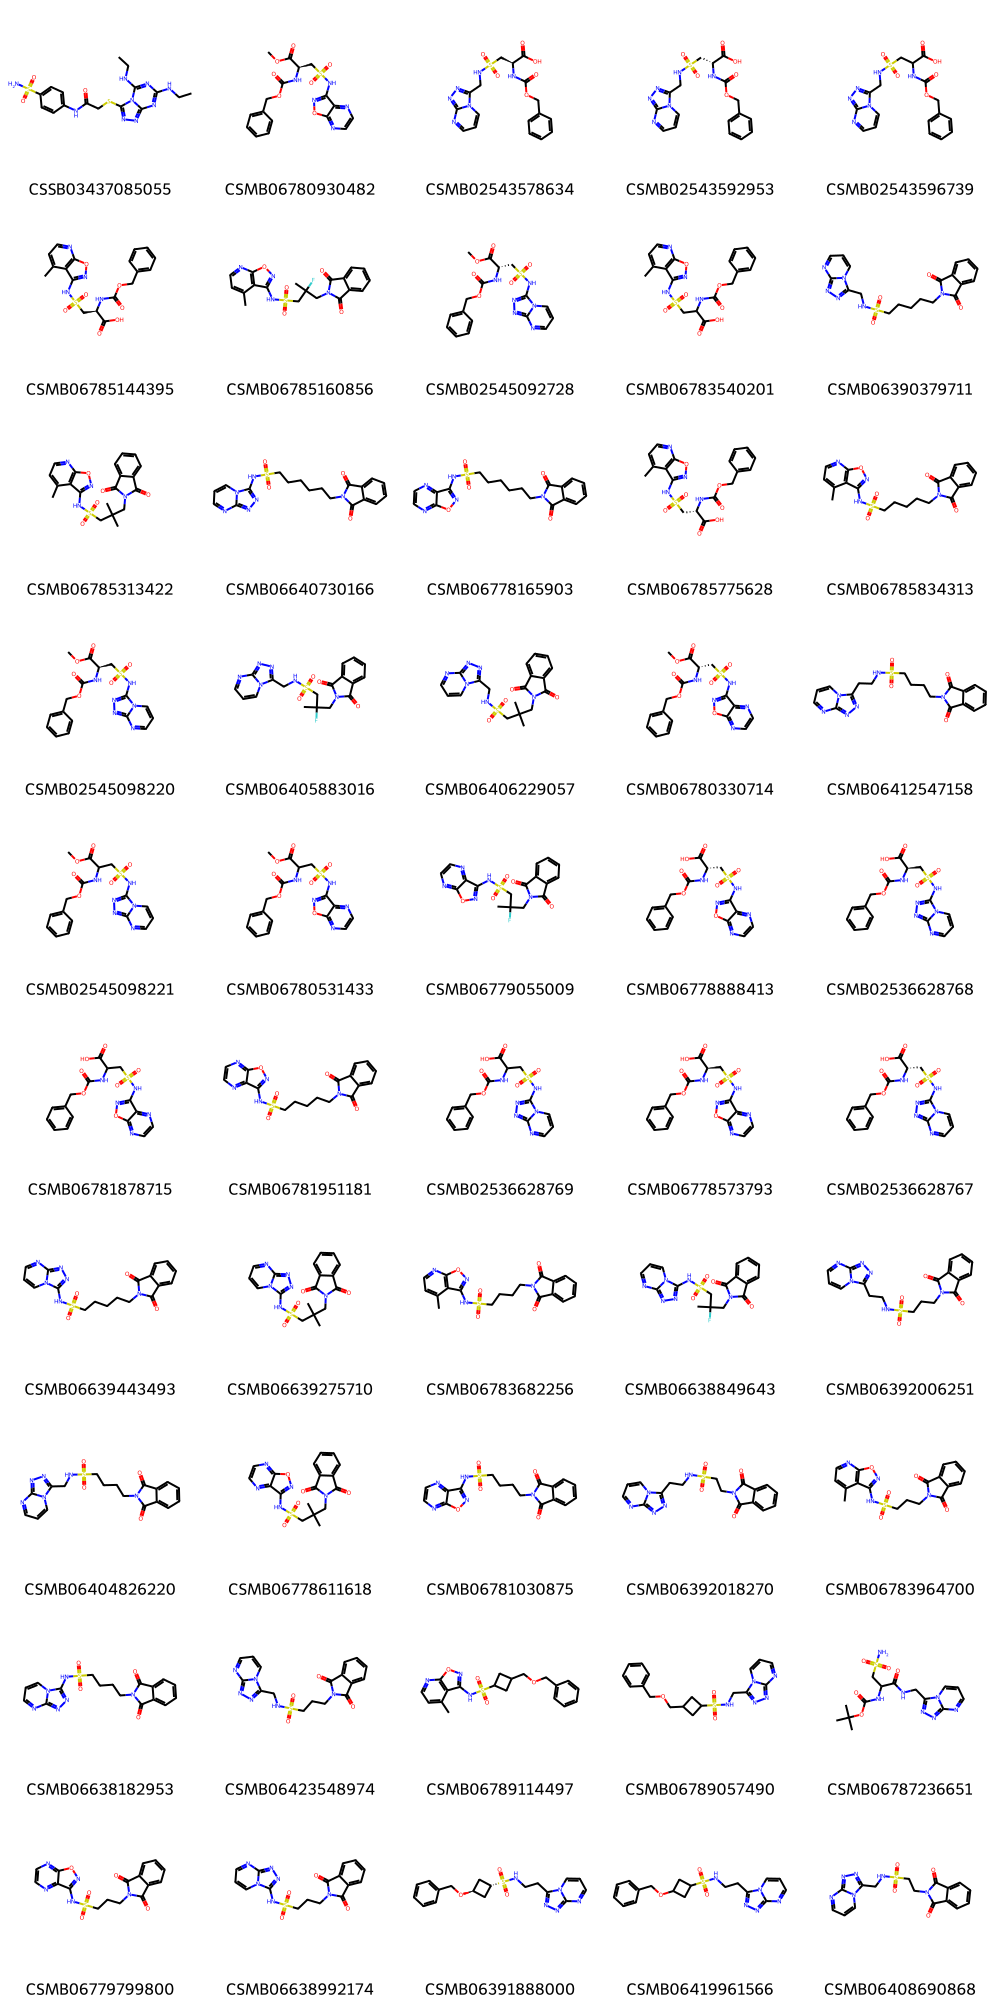

In [145]:
s = matches.loc[matches.mol >= Chem.MolFromSmiles('N-S(=O)(=O)C')].sort_values('N_HA', ascending=False)
Draw.MolsToGridImage(s.mol, legends=s.id.to_list(), molsPerRow=5)

PLAN:

Matching substruture of SMARTS Chem.Mol will give indices. These will have neighbours that do not feature in tuple: R groups.
Add index or isotope to these R groups.
Table time.

Mapping of Inspiration to SMARTS. Mapping of followup to SMARTS
Mapping of latter to former.
Fragmenstein place.

In [158]:
m = Chem.MolFromSmarts('[c,n]')
#AllChem.SanitizeMol(m)
a = m.GetAtomWithIdx(0)
type(a), a.GetSmarts()

rdkit.Chem.rdchem.QueryAtom

In [164]:
set(dir(Chem.QueryAtom)) - set(dir(Chem.Atom))

{'ExpandQuery', 'SetQuery'}

In [168]:
[k for k in dir(a) if 'query' in k.lower()]

['DescribeQuery', 'ExpandQuery', 'GetQueryType', 'HasQuery', 'SetQuery']

(True, '', 'AtomOr\n  AtomType 1006 = val\n  AtomType 1007 = val\n')

In [175]:
Chem.QueryAtom  # RuntimeError: This class cannot be instantiated from Python
Chem.AtomFromSmarts('[c,n]')

In [196]:
mol = Chem.MolFromSmiles('c1cnccc1')

def replace():
aza = mol.GetAtomWithIdx(2)
print(aza.GetSymbol(), aza.GetIdx())
mod = Chem.RWMol(AllChem.AddHs(mol))
mod.ReplaceAtom(aza.GetIdx(), Chem.AtomFromSmarts('[c,n]'), preserveProps=True)
Chem.MolToSmarts(mod.GetMol())

N 2


'[#6]1(:[#6](:[c,n]:[#6](:[#6](:[#6]:1-[H])-[H])-[H])-[H])-[H]'

In [332]:
Chem.QueryAtomData.__class__.__mro__

(rdkit.Chem.rdchem.PropertyPickleOptions, Boost.Python.enum, int, object)

In [277]:
from rdkit import Chem
from typing import Mapping, Sequence

def querimonate(mol: Chem.Mol,
                replacements: Mapping[int, str]={},
                rgroups: Sequence[int]={},
                generic_arocarbons: bool=False) -> mol:
    """
    Given a molecule, convert it to a molecule with query atoms,
    with correct element, number of hydrogens and charge,
    but with overridden values as given by ``replacements`` argument,
    which accepts a dictionary of index (int) to SMARTS (str).
    
    A ``Chem.QueryAtom`` is a special atom with encoded ambiguity.
    ``Chem.MolFromSmarts`` will create a molecule with query atoms, but not a regular mol.
    A query atom has the additional methods
    ``.HasQuery()``, ``.GetQueryType()``, ``.DescribeQuery()``.
    cannot be instantiated from Python, but can be using ``Chem.AtomFromSmarts``.
    
    Additionally, any atom idx in argument ``rgroups`` will get a sequential isotope number from one 
    and property 'R-group' of R + off-by-one number.
    If this index was not in replacements, then the SMARTS will have one connection more than there are
    and one implict hydrogen less.
    
    This function requires ``mol`` to have implicit hydrogens.
    
    ..code-block::python
       queried:Chem.Mol = querimonate(Chem.MolFromSmiles('c1cnccc1'), {2: '[c,n]'})
       Chem.MolToSmarts(queried)
       # '[c&H1]1:[c&H1]:[c,n]:[c&H1]:[c&H1]:[c&H1]:1'
    
    Note 1. ``atom.GetSmarts()`` is a method, but it could return '[N+]' already,
    which is complicated to deal with as appending at given positions may muck things up.
    And certain SMILES are not legal, for example 'CC[O+H2]' should be 'CC[OH2+]'
    
    Note 2. There is no OED word for 'to make into a query'... querify? Shmeh.
    Querimony is a complaint. There is no verb form. This is a jocular neologism,
    as RDKit will complain...
    """
    mod = Chem.RWMol(mol)
    atom: Chem.Atom
    for atom in mod.GetAtoms():
        assert atom.GetNumRadicalElectrons() == 0, 'This molecule has a radical'
        #if not isinstance(atom, Chem.QueryAtom):
        idx: int = atom.GetIdx()
        n_Hs: int = atom.GetImplicitValence() + atom.GetNumExplicitHs()
        symbol: str = atom.GetSymbol().lower() if atom.GetIsAromatic() else atom.GetSymbol()
        scharge: str = get_charge_string(atom)
        # pick relevant SMARTS
        if idx in replacements:
            smarts: str = replacements[idx]
        elif idx in rgroups:
            assert n_Hs == 0, 'R-group requested for zero Hs. Use charge or change element via ``replacement``'
            n_Xs: int = len(atom.GetNeighbors())
            smarts = f'[{symbol}H{n_Hs - 1}X{n_Xs + 1}]'
        elif generic_arocarbons and symbol == 'c' and scharge == '':
            smarts = f'[cH{n_Hs},nH0,oH0,sH0]'
        else:
            smarts = f'[{symbol}H{n_Hs}{scharge}]'
        # swap
        if isinstance(atom, Chem.QueryAtom):
            # weird...
            atom.SetQuery(smarts)
        else:
            mod.ReplaceAtom(idx, Chem.AtomFromSmarts(smarts), preserveProps=True)
    for r, idx in enumerate(rgroups):
        atom = mod.GetAtomWithIdx(idx)
        atom.SetIsotope(r+1)
        atom.SetProp('R-group',f'R{r+1}')
    return mod.GetMol()

def get_charge_string(atom: Chem.Atom) -> str:
    # charge
    charge: int = atom.GetFormalCharge()
    if charge > 0:
        return '+' * abs(charge)
    elif charge < 0:
        return '-' * abs(charge)
    else:
        return ''
    
Chem.MolToSmarts(querimonate(Chem.MolFromSmiles('c1cnccc1'), {2: '[c,n]'}))

'[c&H1]1:[c&H1]:[c,n]:[c&H1]:[c&H1]:[c&H1]:1'

In [321]:
Chem.MolFromSmarts('[C:2]').GetAtomWithIdx(0).DescribeQuery()

'AtomType 6 = val\n'

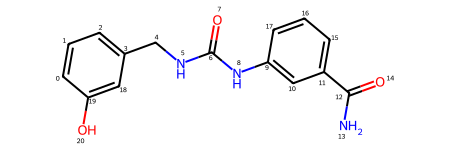

In [345]:
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addAtomIndices = True
Chem.MolFromSmiles('C2=CC=C(CNC(=O)NC1=CC(C(N)=O)=CC=C1)C=C2O')

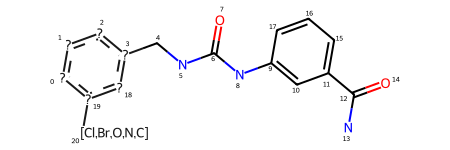

In [346]:
querimonate(Chem.MolFromSmiles('C2=CC=C(CNC(=O)NC1=CC(C(N)=O)=CC=C1)C=C2O'), {0: '[a]', 1: '[a]', 2: '[a]', 3: '[a]', 18: '[a]', 19: '[a]', 20: '[Cl,Br,O,N,C]'}, generic_arocarbons=False)

In [347]:
Chem.MolToSmarts(_)

'a1:a:a:a(-[C&H2]-[N&H1]-[C&H0](=[O&H0])-[N&H1]-[c&H0]2:[c&H1]:[c&H0](-[C&H0](-[N&H2])=[O&H0]):[c&H1]:[c&H1]:[c&H1]:2):a:a:1-[Cl,Br,O,N,C]'

In [295]:
Chem.MolToSmarts(querimonate(Chem.MolFromSmiles('c1cnc[nH1+]c1'), {2: '[c,n]'}))

'[c&H1]1:[c&H1]:[c,n]:[c&H1]:[n&H1&+]:[c&H1]:1'

In [302]:
a = Chem.MolFromSmiles('[OH]C').GetAtomWithIdx(0)

a, a.GetImplicitValence()

(1, 0)

In [306]:

        #smarts: str = 

[10:47:37] SMILES Parse Error: syntax error while parsing: [C2+]
[10:47:37] SMILES Parse Error: Failed parsing SMILES '[C2+]' for input: '[C2+]'


In [303]:
Chem.MolFromSmiles('CC[OH2+]'), Chem.MolFromSmiles('CC[O+H2]')

[10:47:12] SMILES Parse Error: syntax error while parsing: CC[O+H2]
[10:47:12] SMILES Parse Error: Failed parsing SMILES 'CC[O+H2]' for input: 'CC[O+H2]'


(<rdkit.Chem.rdchem.Mol at 0x7f30ad97ccf0>, None)

In [267]:
Chem.MolFromSmiles('CC[OH2+]').GetSubstructMatch( Chem.MolFromSmarts('CC[OH2+]'))

(0, 1, 2)

In [269]:
Chem.MolToSmarts(Chem.MolFromSmarts('CC[OH2+]')),\
Chem.MolToSmarts(Chem.MolFromSmarts('CC[O+H2]')),

('CC[O&H2&+]', 'CC[O&+&H2]')

In [174]:
# code to get xref ids from Zinc

import requests, collections, contextlib
from bs4 import BeautifulSoup

class ZincInformer(collections.abc.MutableMapping):
    """
    Get Zinc info.
    
    A class that stores the retieved values —in ``.data`` (``.dump`` and ``.load`` to store).
    The values can be accessed as a subscript or by calling the instance,
    the latter captures errors declared during initialisation by the argument ``suppressed_exception``.
    
    .. code-block::python
        zinfo = ZincInformer()
        series.apply(zinfo)
    """
    
    def __init__(self, suppressed_exception=Exception):
        self.data = {}
        self.suppressed_exception = suppressed_exception
        
    def __getitem__(self, zinc_id):
        if zinc_id not in self.data:
            soup = get_soup(zinc_id)
            self.data[zinc_id] = self.get_zinc_info(zinc_id, soup)
        return self.data[zinc_id]
    
    def __call__(self, zinc_id):
        with contextlib.suppress(self.suppressed_exception):
            return self[zinc_id]
        self[zinc_id] = {}
        return {}
    
    def __setitem__(self, zinc_id: str, info: dict):
        self.data[zinc_id] = info
        
    def __delitem__(self, zinc_id):
        del self.data[zinc_id]
        
    def __iter__(self):
        return iter(self.data)
    
    def __len__(self):
        return len(self.data)
    
    def dump(self, filename:str='zinc.json'):
        with open(filename, 'w') as fh:
            json.dump(self.data, fh)
            
    def load(self, filename:str='zinc.json'):
        with open(filename, 'r') as fh:
            self.data = json.load(fh)
            
    # ======== specific methods
    
    @classmethod
    def get_soup(self, zinc_id: str) -> BeautifulSoup:
        """parse HTML. Return a soup"""
        response = requests.get(f'https://zinc.docking.org/substances/{zinc_id}')
        response.raise_for_status()
        return BeautifulSoup(response.text, 'html.parser')

    @classmethod
    def get_dl(self, soup: BeautifulSoup) -> dict:
        """
        Data tables are organised in dl entries, dt headers and dd fields.
        """
        keys, values = [], []
        for dl in soup.findAll("dl"):
            for dt in dl.findAll("dt"):
                keys.append(dt.text.strip())
            for dd in dl.findAll("dd"):
                values.append(dd.text.strip())
        return dict(zip(keys, values))

    @classmethod
    def polísh(self, dl: dict) -> dict:
        """
        There's a bunch of words that get in the way...
        """
        return {k.replace('Bioactive', '').replace('Natural Products', '').replace('Building Blocks','').strip(): v for k, v in dl.items()}

    @classmethod
    def get_zinc_info(self, zinc_id, soup):
        """
        These fields ought to always exist!
        """
        return {'query_name': zinc_id,
                'title': soup.title.text.strip(),
                'SMILES': soup.find('input', dict(id="substance-smiles-field")).attrs['value'].strip(),
                'inchi': soup.find('input', dict(id="substance-inchi-field")).attrs['value'].strip(),
                'inchikey': soup.find('input', dict(id="substance-inchikey-field")).attrs['value'].strip(),
                **self.polísh(self.get_dl(soup))
               }

In [ ]:
zinfo = ZincInformer()

matches['id'].apply(zinfo)

In [ ]:
smarts = Chem.MolFromSmarts('[!C])
matches.mol.apply(lambda m: m.HasSubstructMatch(smarts)

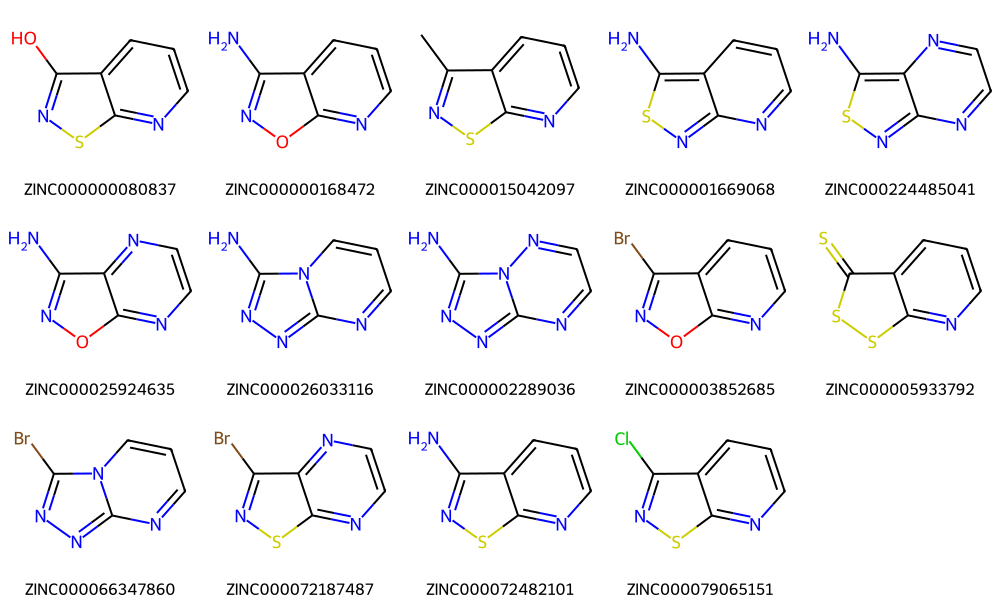

In [343]:
s = matches.loc[(matches.N_HA <= 10) & (matches.db == 'BB-50-22Q1')]
Draw.MolsToGridImage(s.mol, legends=s.id.to_list(), molsPerRow=5)

#x1594_0A_1

In [342]:
s.set_index('id').smiles.to_dict()

{'ZINC000000080837': 'Oc1nsc2ncccc12',
 'ZINC000000168472': 'Nc1noc2ncccc12',
 'ZINC000012397068': 'Cc1noc2ncc(N)cc12',
 'ZINC000015042097': 'Cc1nsc2ncccc12',
 'ZINC000017061891': 'Cc1noc2nc[nH]c(=O)c12',
 'ZINC000001669068': 'Nc1snc2ncccc12',
 'ZINC000001674121': 'Cc1noc2ncnc(N)c12',
 'ZINC000019779146': 'Cc1ccc2c(N)noc2n1',
 'ZINC000224485041': 'Nc1snc2nccnc12',
 'ZINC000238711097': 'Nc1snc2ncc(Br)cc12',
 'ZINC000025924635': 'Nc1noc2nccnc12',
 'ZINC000026033116': 'Nc1nnc2ncccn12',
 'ZINC000002289036': 'Nc1nnc2nccnn12',
 'ZINC000003852685': 'Brc1noc2ncccc12',
 'ZINC000039191805': 'Cc1nsc2nc[nH]c(=O)c12',
 'ZINC000045921422': 'Cc1noc2ncnc(Cl)c12',
 'ZINC000051951618': 'BrCc1noc2ncccc12',
 'ZINC000005933792': 'S=c1ssc2ncccc12',
 'ZINC000066323473': 'Cc1ccn2c(N)nnc2n1',
 'ZINC000066347860': 'Brc1nnc2ncccn12',
 'ZINC000072187487': 'Brc1nsc2nccnc12',
 'ZINC000072482101': 'Nc1nsc2ncccc12',
 'ZINC000079065151': 'Clc1nsc2ncccc12',
 'ZINC000082372119': 'Cc1nnc2ncc(Br)cn12',
 'ZINC000082372152'

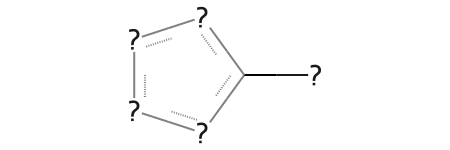

In [38]:
smol = Chem.MolFromSmarts('[aH0X3]1c(-[Br,Cl,NH2])[aH0X2][aH0X2][c,n;H1]1')
smol

True


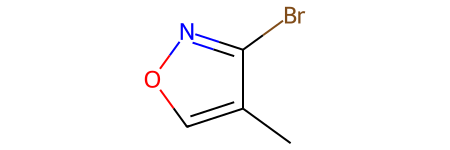

In [40]:
mol = Chem.MolFromSmiles('Cc1c(-[Br])[nH0][oH0]c1')
print(mol.HasSubstructMatch(smol))
mol

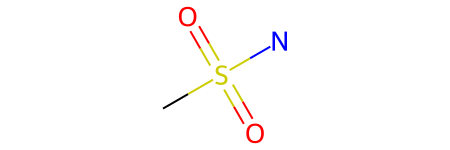

In [42]:
Chem.MolFromSmarts('N-S(=O)(=O)-C')

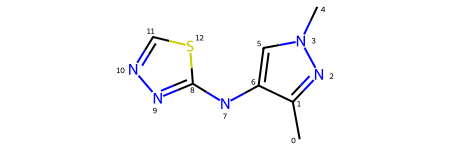

In [296]:
querimonate(Chem.MolFromSmiles('Cc1nn(C)cc1Nc1nncs1'), replacements={4: 'C', 0: 'C'})

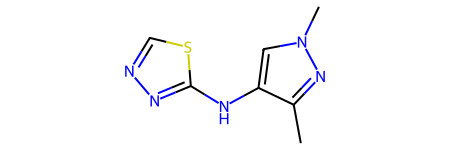

In [6]:
Chem.MolFromSmiles('Cc1nn(C)cc1Nc1nncs1')

In [ ]:
IPythonConsole.drawOptions.addAtomIndices = True

x1594 = hitdex['x1594_0A§1']
mol = x1594
m = Chem.Mol(x1594)
AllChem.Compute2DCoords(m)
display(m)
AllChem.SanitizeMol(mol)
assert len(mol.GetSubstructMatches(s)) == 1
keepers = mol.GetSubstructMatches(s)[0]
print(keepers)
with Chem.RWMol(mol) as rwmol:
    for atom in rwmol.GetAtoms():
        ai: int = atom.GetIdx()
        if ai not in keepers:
            rwmol.RemoveAtom(ai)
x1594_skeleton = rwmol.GetMol()        
m = Chem.Mol(x1594_skeleton)
AllChem.Compute2DCoords(m)
m

In [13]:
'''x1594_0A§1
     RDKit          3D

 10 11  0  0  0  0  0  0  0  0999 V2000
   -6.8740    9.8340  -32.5350 N   0  0  0  0  0  0  0  0  0  0  0  0
   -6.6660   10.2800  -31.2910 C   0  0  0  0  0  0  0  0  0  0  0  0
   -5.8820   11.4760  -29.6270 C   0  0  0  0  0  0  0  0  0  0  0  0
   -7.1990    9.8070  -30.1740 N   0  0  0  0  0  0  0  0  0  0  0  0
   -5.0830   12.4690  -29.0140 C   0  0  0  0  0  0  0  0  0  0  0  0
   -6.7030   10.5680  -29.1130 N   0  0  0  0  0  0  0  0  0  0  0  0
   -4.2680   13.2420  -29.7830 C   0  0  0  0  0  0  0  0  0  0  0  0
   -5.8120   11.3450  -31.0120 N   0  0  0  0  0  0  0  0  0  0  0  0
   -4.2110   13.0710  -31.1840 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.9820   12.1370  -31.7840 C   0  0  0  0  0  0  0  0  0  0  0  0
  1  2  1  0
  2  4  2  0
  2  8  1  0
  3  5  1  0
  3  6  2  0
  3  8  1  0
  4  6  1  0
  5  7  2  0
  7  9  1  0
  8 10  1  0
  9 10  2  0
A    1
 N  
A    2
 C  
A    3
 C1 
A    4
 N1 
A    5
 C2 
A    6
 N2 
A    7
 C3 
A    8
 N3 
A    9
 C4 
A   10
 C5 
M  END
'''

'x1594_0A§1\n     RDKit          3D\n\n 10 11  0  0  0  0  0  0  0  0999 V2000\n   -6.8740    9.8340  -32.5350 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.6660   10.2800  -31.2910 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.8820   11.4760  -29.6270 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -7.1990    9.8070  -30.1740 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.0830   12.4690  -29.0140 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -6.7030   10.5680  -29.1130 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.2680   13.2420  -29.7830 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -5.8120   11.3450  -31.0120 N   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.2110   13.0710  -31.1840 C   0  0  0  0  0  0  0  0  0  0  0  0\n   -4.9820   12.1370  -31.7840 C   0  0  0  0  0  0  0  0  0  0  0  0\n  1  2  1  0\n  2  4  2  0\n  2  8  1  0\n  3  5  1  0\n  3  6  2  0\n  3  8  1  0\n  4  6  1  0\n  5  7  2  0\n  7  9  1  0\n  8 10  1  0\n  9 10  2  0\nA    1\n N  \nA    2\n C  \nA    3\n C1 \nA    4\n N1 \n

In [ ]:
x1594, fippedSulfonamide

In [21]:
for i in range(10):
    print(monstah.positioned_mol.GetAtomWithIdx(i).GetPropsAsDict())

{'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEE object at 0x169efc340>, '_Stdev': 0.0, '_Origin': '["fippedSulfonamide.1"]', '_Max': 0.0}
{'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEE object at 0x169efc340>, '_Stdev': 0.0, '_Origin': '["fippedSulfonamide.0"]', '_Max': 0.0}
{'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEE object at 0x169efc340>, '_Stdev': 0.0, '_Origin': '["fippedSulfonamide.2"]', '_Max': 0.0}
{'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEE object at 0x169efc340>, '_Stdev': 0.0, '_Origin': '["fippedSulfonamide.3"]', '_Max': 0.0}
{'__computedProps': <rdkit.rdBase._vectNSt3__112basic_stringIcNS_11char_traitsIcEENS_9allocatorIcEEEE object at 0x169efc340>, '_Stdev': 0.0, '_Origin': '["fippedSulfonamide.4"]', '_Max': 0.0}
{'__computedProps': <rdkit.rdBase._vectN

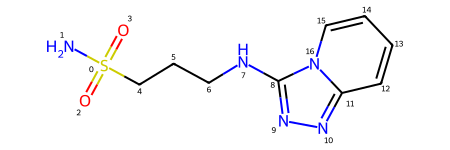

In [6]:
mol = Chem.MolFromSmiles('S(N)(=O)(=O)CCCNc1nnc2ccccn12')
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
mol

In [17]:
originses = [['F04.0'], ['F04.1'], ['F04.2'], ['F04.3'], [], ['F04.5'], ['F04.13'], ['F04.7'], ['F04.8'], ['F04.9'], ['F04.10'], ['F04.11'], ['F04.12'], ['F04.6'], ['F04.15'], ['F04.14']]
all([('F04.4' not in origin) for origins in originses for origin in origins])

True

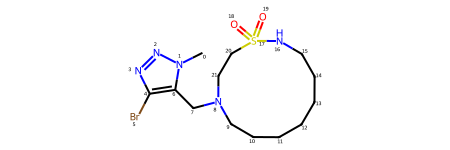

In [24]:
pennyfarthing = Chem.MolFromSmiles('CN1N=NC(Br)=C1CN1CCCCCCCNS(=O)(=O)CC1')
pennyfarthing